In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tensorflow import keras
import pandas as pd
from tqdm import tqdm
import glob
import PIL
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
model = tf.keras.models.load_model('classificatio_model_20220221.h5')

In [3]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                10250     
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
softmax (Softmax)            (None, 10)                0         
Total params: 1,540,258
Trainable params: 1,528,126
Non-trainable params: 12,132
______________________________________________

In [4]:
RES = 224
N_BATCH = 64

N_CLASS = 6
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 50
# learning rate
LR = 0.0001


In [5]:
folder_list = os.listdir('seg_train/seg_train')
folder_list

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [83]:
# image_list = glob.glob(folder_list + '*.png')
map = pd.DataFrame(columns=['image_path', '0', '1', '2', '3', '4', '5', '6' , '7', '8', '9'])


for folder in folder_list:
    
    images_list = glob.glob('seg_train/seg_train/' + folder + '/*.jpg')
    # print(len(images))
    
    for image_path in images_list:
        # print(type(image))
        # print(images)
        # img = tf.io.decode_image(image_path)
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=(RES, RES))
        # img = tf.image.decode_jpeg(image_path)
        # img = tf.image.resize(img, (RES, RES))
        # img = tf.keras.preprocessing.resize(img)
        # print(img.shape)
        img_tensor = tf.keras.preprocessing.image.img_to_array(img)
        # print(img_tensor.shape)
        # img_tensor = img_tensor[tf.newaxis, ...]
        pred = model.predict(img_tensor[tf.newaxis, ...])
        
        map = map.append({'image_path' : image_path, 
                    '0' : pred[0][0],
                    '1' : pred[0][1], 
                    '2' : pred[0][2], 
                    '3' : pred[0][3], 
                    '4' : pred[0][4], 
                    '5' : pred[0][5], 
                    '6' : pred[0][6], 
                    '7' : pred[0][7], 
                    '8' : pred[0][8], 
                    '9' : pred[0][9]}, ignore_index=True)
        
        
map
        
        



,image_path,0,1,2,3,4,5,6,7,8,9
0,seg_train/seg_train/buildings\0.jpg,9.999973e-01,1.310604e-07,1.787436e-07,7.618311e-08,1.701847e-06,6.693180e-07,1.496803e-10,8.657843e-11,6.080526e-11,3.717447e-11
1,seg_train/seg_train/buildings\10006.jpg,9.958069e-01,1.369415e-05,1.027639e-04,4.709766e-05,1.020008e-06,4.028426e-03,3.512399e-09,2.567477e-09,1.511650e-09,1.157347e-09
2,seg_train/seg_train/buildings\1001.jpg,1.000000e+00,2.730563e-10,1.343635e-09,1.999359e-12,3.560028e-10,2.493205e-10,2.404904e-12,3.642356e-12,7.895574e-13,1.656980e-13
3,seg_train/seg_train/buildings\10014.jpg,9.999427e-01,1.044689e-06,3.775684e-06,1.475896e-07,5.088514e-05,1.435213e-06,9.688240e-10,3.929236e-10,6.583157e-10,1.881729e-10
4,seg_train/seg_train/buildings\10018.jpg,9.765536e-01,6.449068e-07,3.464531e-06,3.370753e-06,2.343876e-02,1.224259e-07,5.889479e-09,2.356804e-09,1.225480e-08,6.115324e-09
...,...,...,...,...,...,...,...,...,...,...,...
14029,seg_train/seg_train/street\9961.jpg,8.414716e-04,1.508136e-05,3.910893e-05,1.206998e-06,2.320793e-06,9.991008e-01,8.703082e-09,8.261377e-09,3.381182e-09,5.613283e-09
14030,seg_train/seg_train/street\9967.jpg,1.884286e-07,2.513922e-08,4.586007e-08,2.128762e-08,2.239947e-10,9.999998e-01,1.116498e-10,2.744554e-11,1.109578e-10,4.007054e-10
14031,seg_train/seg_train/street\9978.jpg,2.760508e-06,3.313318e-07,1.873064e-06,1.056775e-06,2.502285e-10,9.999939e-01,1.608741e-08,5.666103e-09,6.252014e-09,8.705363e-09
14032,seg_train/seg_train/street\9989.jpg,2.601525e-06,1.321206e-06,7.816200e-06,1.521538e-07,3.838730e-08,9.999881e-01,3.986500e-10,7.932077e-11,6.914852e-11,1.440860e-10


In [85]:
map.to_csv('classified_map_20220222.csv')

In [6]:
classified_map = pd.read_csv('classified_map_20220222.csv')

In [7]:
classified_map.rename(columns={'Unnamed: 0' : 'index'}, inplace=True)

In [8]:
# print(get_idx('seg_train/seg_train/street\999.jpg'))
# print(get_label('seg_train/seg_train/street\999.jpg'))

classified_map

,index,image_path,0,1,2,3,4,5,6,7,8,9
0,0,seg_train/seg_train/buildings\0.jpg,9.999973e-01,1.310604e-07,1.787436e-07,7.618311e-08,1.701847e-06,6.693180e-07,1.496803e-10,8.657843e-11,6.080526e-11,3.717447e-11
1,1,seg_train/seg_train/buildings\10006.jpg,9.958069e-01,1.369415e-05,1.027639e-04,4.709766e-05,1.020008e-06,4.028426e-03,3.512399e-09,2.567477e-09,1.511650e-09,1.157347e-09
2,2,seg_train/seg_train/buildings\1001.jpg,1.000000e+00,2.730563e-10,1.343635e-09,1.999359e-12,3.560028e-10,2.493205e-10,2.404904e-12,3.642356e-12,7.895574e-13,1.656980e-13
3,3,seg_train/seg_train/buildings\10014.jpg,9.999427e-01,1.044689e-06,3.775684e-06,1.475896e-07,5.088514e-05,1.435213e-06,9.688240e-10,3.929236e-10,6.583157e-10,1.881729e-10
4,4,seg_train/seg_train/buildings\10018.jpg,9.765536e-01,6.449068e-07,3.464531e-06,3.370753e-06,2.343876e-02,1.224259e-07,5.889479e-09,2.356804e-09,1.225480e-08,6.115324e-09
...,...,...,...,...,...,...,...,...,...,...,...,...
14029,14029,seg_train/seg_train/street\9961.jpg,8.414716e-04,1.508136e-05,3.910893e-05,1.206998e-06,2.320793e-06,9.991008e-01,8.703082e-09,8.261377e-09,3.381182e-09,5.613283e-09
14030,14030,seg_train/seg_train/street\9967.jpg,1.884286e-07,2.513922e-08,4.586007e-08,2.128762e-08,2.239947e-10,9.999998e-01,1.116498e-10,2.744554e-11,1.109578e-10,4.007054e-10
14031,14031,seg_train/seg_train/street\9978.jpg,2.760508e-06,3.313318e-07,1.873064e-06,1.056775e-06,2.502285e-10,9.999939e-01,1.608741e-08,5.666103e-09,6.252014e-09,8.705363e-09
14032,14032,seg_train/seg_train/street\9989.jpg,2.601525e-06,1.321206e-06,7.816200e-06,1.521538e-07,3.838730e-08,9.999881e-01,3.986500e-10,7.932077e-11,6.914852e-11,1.440860e-10


In [9]:
def get_idx(x):
    # str = x.split('/')
    return x.split('\\')[1][:-4]

In [10]:
def get_label(x):
    return x.split('/')[2].split('\\')[0]

In [11]:
classified_map['idx'] = classified_map.image_path.map(get_idx)
classified_map['label'] = classified_map.image_path.map(get_label)

In [12]:
cc_map = classified_map.copy()

In [44]:
# test_map = pd.concat([classified_map, pd.get_dummies(classified_map['label'])])
# tt = pd.get_dummies(classified_map['label'])

# cc_map['labels_category'] = 0 

# for (idx1, val1), (idx2, val2) in zip(cc_map.iterrows(), tt.iterrows()):
# #     val1['labels'] = [val2['buildings'], val2['forest'], val2['glacier'], val2['mountain'], val2['sea'], val2['street']]
#     # print([val2['buildings'], val2['forest'], val2['glacier'], val2['mountain'], val2['sea'], val2['street']])
#     # cc_map['labels_category'] = 
#     # cc_map['labels_category'] = [val2['buildings'], val2['forest'], val2['glacier'], val2['mountain'], val2['sea'], val2['street']]
    
    
# # cc_map
# cc_map

# category_classified_map = classified_map['label'].astype('category')
# category_classified_map.loc[].values.codes

array([0, 0, 0, ..., 5, 5, 5], dtype=int8)

In [108]:
# np.array(tt.loc[0, ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']]), np.ndarray(tt.loc[0, ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']])

(array([1, 0, 0, 0, 0, 0], dtype=uint8),
 array([], shape=(1, 0, 0, 0, 0, 0), dtype=float64))

In [48]:
# get_random_map(1, 2)
np.argsort(classified_map.iloc[1, 2:11].values, axis=0)[-2]
# np.argsort(map.iloc[1, 2:].values, axis=0)
# map.iloc[1, 2:11].values

3

In [27]:
imgs = [] 
for idx, val in classified_map[:3].iterrows():
    img = tf.keras.preprocessing.image.load_img(val['image_path'], target_size=(RES, RES))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    
    imgs.append(img_tensor)
    
# print(imgs.shape)
# print(tf.stack(imgs).shape)

# 잊을 까봐 적는, 
# image stack 을 쌓아서 그냥 Tensor 형태로 만들면 되겠구나 
# 

image_path1 = classified_map.loc[0, 'image_path']
image_path2 = classified_map.loc[1, 'image_path']


img1 = tf.keras.preprocessing.image.load_img(image_path1, target_size=(RES, RES))
img_tensor1 = tf.keras.preprocessing.image.img_to_array(img1)

img2 = tf.keras.preprocessing.image.load_img(image_path2, target_size=(RES, RES))
img_tensor2 = tf.keras.preprocessing.image.img_to_array(img2)

# plt.imshow(img_tensor1 / 255)
# plt.imshow(img_tensor2 / 255)

# plt.show()
llll = [] 
llll.append(img_tensor1)
llll.append(img_tensor2)

kkkk = tf.stack(llll)


print(kkkk.shape)

(2, 224, 224, 3)


In [72]:
images = [] 
labels = [] 

imgs = []
labs = [] 

classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

for idx, val in classified_map.iterrows():
    
    # image
    img1 = tf.keras.preprocessing.image.load_img(val['image_path'], target_size=(RES, RES))
    image1 = tf.keras.preprocessing.image.img_to_array(img1)
    
    # label 
    # label1 = np.ndarray(tt.loc[idx, classes], dtype=np.float32) 
    label1 = tt.loc[idx, classes].to_numpy()
    
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) 
    # idx = tf.random.uniform((), 0, N_BATCH, tf.int32)
    # idx = get_random_map(i, 2) 
    
    # randomely picked 
    rand_df = classified_map[classified_map['label'] != val['label']].sample(n=1)
    
    # randomly picked image
    img2 = tf.keras.preprocessing.image.load_img(rand_df['image_path'].values[0], target_size=(RES, RES))
    image2 = tf.keras.preprocessing.image.img_to_array(img2)
    
    # randomly picked label
    # label2 = np.ndarray(tt.loc[rand_df['index'].values[0], classes], dtype=np.float32)
    label2 = tt.loc[rand_df['index'].values[0], classes].to_numpy()
    

    w = RES 
    h = RES 

    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam) 
    cut_w = tf.cast(w * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(h * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(w/8), int(7/8*w), tf.int32)
    cy = tf.random.uniform((), int(h/8), int(7/8*h), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, w)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, h)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, w)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, h)

    # mid_left = image[i, ymin:ymax, :xmin, :]
    # mid_mid = image[idx, ymin:ymax, xmin:xmax, :]
    # mid_right = image[i, ymin:ymax, xmax:, :]
    # middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) 
    # top = image[i, :ymin, :, :]
    # bottom = image[i, ymax:, :, :]
    
    mid_left = image1[ymin:ymax, :xmin, :]
    mid_mid = image2[ymin:ymax, xmin:xmax, :]
    mid_right = image1[ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) 
    top = image1[:ymin, :, :]
    bottom = image1[ymax:, :, :]

    new_imgs = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_imgs)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin

    alpha = tf.cast((cut_w_mod * cut_h_mod) / (w*h), tf.float32)

    # print(f'type label1 : {label1}')
    # print(f'type label1 : {type(label1)}')
    # print(f'type label1 : {label1.dtype}')
    # print(f'type label2 : {label2}')
    # print(f'type label2 : {type(label2)}')
    # print(f'type label2 : {label2.dtype}')
    
    # label1 = tf.convert_to_tensor(label1)
    # label2 = tf.convert_to_tensor(label2)
    
    # print(f'type label1 : {type(label1)}')
    # print(f'type label1 : {label1.dtype}')
    # print(f'type label2 : {type(label2)}')
    # print(f'type label2 : {label2.dtype}')

    new_label = ((1-alpha) * label1 + alpha * label2) 
    labs.append(new_label)
    
    
images = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
labels = tf.reshape(tf.stack(labs), [-1, 6])

# APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) 

print(images.shape)
print(labels.shape)
    

(14034, 224, 224, 3)
(14034, 6)


tf.Tensor([0.5770488  0.42295122 0.         0.         0.         0.        ], shape=(6,), dtype=float32)
tf.Tensor([0.41394293 0.         0.         0.         0.         0.58605707], shape=(6,), dtype=float32)
tf.Tensor([0.63950896 0.         0.         0.         0.         0.36049107], shape=(6,), dtype=float32)
tf.Tensor([0.82389987 0.         0.         0.17610013 0.         0.        ], shape=(6,), dtype=float32)
tf.Tensor([0.5512197 0.4487803 0.        0.        0.        0.       ], shape=(6,), dtype=float32)


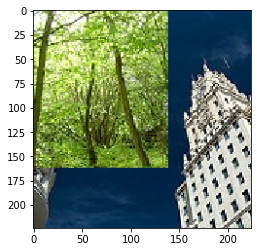

In [77]:
for image, label in zip(images[:5], labels[:5]):
    plt.imshow(image / 255)
    # print(image.shape)
    print(label)
    
plt.show()

In [78]:
train_ds = tf.data.Dataset.from_tensor_slices((images, labels))

In [83]:
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [84]:
def create_model():
    inputs = keras.Input(shape=(RES, RES, 3))
    x = preprocess_input(inputs)
    x = mobilenetv3(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(N_CLASS)(x)
    x = BatchNormalization()(x)
    outpus = Softmax()(x)
    model = keras.Model(inputs=inputs, outputs=outpus)
    return model

In [90]:
model = create_model()

In [91]:
train_ds = train_ds.shuffle(100).batch(32) 

In [92]:
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [93]:
# def loss_object(): 
# loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
loss_object = tf.keras.losses.CategoricalCrossentropy() 
optimizer = tf.keras.optimizers.Adam()

In [94]:
@tf.function 
def train_step(images, label): 
    with tf.GradientTape() as tape: 
        prediction = model(images)
        loss = loss_object(label, prediction) 
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, prediction)

In [103]:
for epoch in range(1): 

    for image, label in train_ds.take(2): 
        # train_step(image, label) 
        # print(type(image))
        # print(image.shape)
        # print(image.dtype)
        # print('---------')
        print(type(label))
        # print(label.shape)
        # print(label.dtype)
        print(label[0].numpy())
        print('#########')

    # for images, label in test_ds: 
        # test_step(images, label) 

    # temp = 'epoch : {}, loss : {}, accuracy : {}, test_loss : {}, test_accuracy : {}'
    # temp = 'epoch : {}, loss : {}, accuracy : {}'
    # print(temp.format(epoch+1
    #                 , train_loss.result() 
    #                 , train_accuracy.result() * 100))
                    # , test_loss.result() 
                    # , test_accuracy.result() * 100))


<class 'tensorflow.python.framework.ops.EagerTensor'>
[0.28910238 0.         0.         0.         0.         0.7108976 ]
#########
<class 'tensorflow.python.framework.ops.EagerTensor'>
[1. 0. 0. 0. 0. 0.]
#########


In [105]:
model.compile(keras.optimizers.Adam(LR), loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

model.fit(train_ds, epochs=N_EPOCH)

Epoch 1/50
439/439 [==============================] - 455s 993ms/step - loss: 1.6942 - accuracy: 0.4302
Epoch 2/50
439/439 [==============================] - 436s 993ms/step - loss: 1.5944 - accuracy: 0.5326
Epoch 3/50
439/439 [==============================] - 420s 956ms/step - loss: 1.5597 - accuracy: 0.5831
Epoch 4/50
439/439 [==============================] - 434s 988ms/step - loss: 1.5400 - accuracy: 0.6072
Epoch 5/50
439/439 [==============================] - 424s 966ms/step - loss: 1.5179 - accuracy: 0.6357
Epoch 6/50
439/439 [==============================] - 411s 936ms/step - loss: 1.5020 - accuracy: 0.6563
Epoch 7/50
110/439 [======>.......................] - ETA: 5:10 - loss: 1.5032 - accuracy: 0.6384

KeyboardInterrupt: 